In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, datasets, metrics
from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix, f1_score, precision_recall_curve, precision_score, recall_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt

In [4]:
import os
os.chdir('/data/home/ldhyun7222/hERGAT')
#test_df= pd.read_csv('./dataset/external dataset/hERGSPred_dataset_with_canonical_smiles.csv')
#test_df= pd.read_csv('./dataset/external dataset/deep_learning_dataset_with_canonical_smiles.csv')
#test_df= pd.read_csv('./dataset/external dataset/CardioTox_dataset_with_canonical_smiles.csv')

In [5]:
train_df= pd.read_csv('./another method/train_df2.csv')
test_df= pd.read_csv('./another method/test_df2.csv')
X_train = train_df.drop(columns = ['Class', 'SMILES', 'cano_smiles'])
y_train = train_df['Class']

X_test = test_df.drop(columns = ['Class', 'SMILES', 'cano_smiles'])
y_test = test_df['Class']

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8314, 1029)
(8314,)
(924, 1029)
(924,)


In [7]:
# #n_estimators=50,max_features=24, max_depth=190

# rand = RandomForestClassifier()
# parameters = {'n_estimators':[10,30,50,70,90], 'max_features':[18,20,22,24],'max_depth':[100,130,150,170]}
# rf = RandomizedSearchCV(rand,parameters,n_iter=50, cv=10, refit=True, return_train_score=True)
# rf.fit(X=X_train, y=y_train)

# # 최적 파라미터 출력
# print("Best Parameters:", rf.best_params_)

# # 가장 낮은 성능의 하이퍼파라미터 조합 찾기
# min_index = np.argmin(rf.cv_results_['mean_test_score'])
# worst_params = {key: rf.cv_results_['params'][min_index][key] for key in parameters}
# print("Worst Parameters:", worst_params)

best+params : n_estimators=50,max_features=24, max_depth=190

In [8]:
model = RandomForestClassifier(random_state=90, n_estimators=50, max_features=24, max_depth=150)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]


pred_train = model.predict(X_train)


train_score = accuracy_score(y_train,pred_train)
Precision = precision_score(y_test, y_pred)
Recall = recall_score(y_test, y_pred)
F1_score = 2*(Precision*Recall)/(Precision+Recall)

precisions, recalls, _ = precision_recall_curve(y_test, y_pred_proba)
AUPR = auc(recalls, precisions)

print('accuracy : {0}'.format(accuracy_score(y_test, y_pred)))
print('Precision : {0}'.format(Precision))
print('Recall : {0}'.format(Recall))
print('ROC_score :', roc_auc_score(y_test, y_pred_proba))
print('AUPRC : {0}'.format(AUPR))
print("F1 score : {0}".format(F1_score))

accuracy : 0.8138528138528138
Precision : 0.8183254344391785
Recall : 0.9008695652173913
ROC_score : 0.8829749595116481
AUPRC : 0.9172217528415305
F1 score : 0.8576158940397349


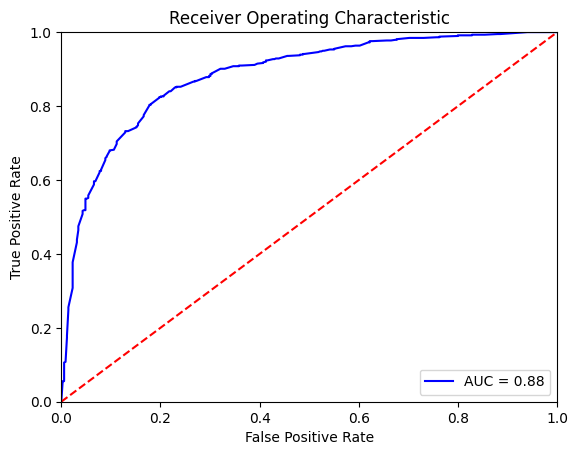

In [9]:
# ROC curve
from sklearn.metrics import roc_auc_score,roc_curve,auc

rf_fpr, rf_tpr, threshold = roc_curve(y_test, y_pred_proba)
rf_roc_auc = auc(rf_fpr, rf_tpr)

roc = pd.DataFrame({
    'FPR': rf_fpr,
    'TPRate': rf_tpr,
    'Threshold': threshold
})

optimal_idx=np.argmax(rf_tpr-rf_fpr)
optimal_threshold= threshold[optimal_idx]


plt.title('Receiver Operating Characteristic')
plt.plot(rf_fpr, rf_tpr, 'b', label = 'AUC = %0.2f' % rf_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

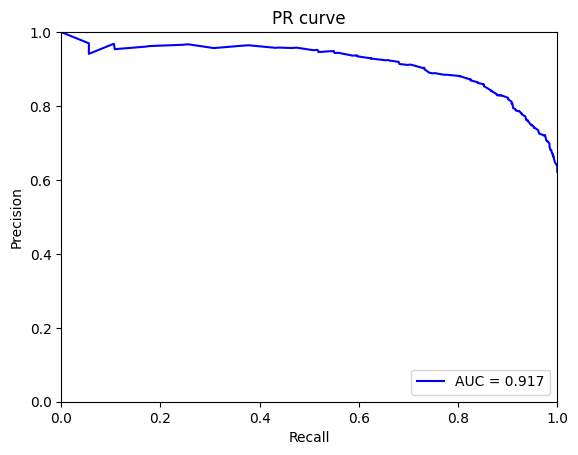

In [10]:
# precision, recall, threshold 
rf_precision, rf_recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
# pr_auc
rf_pr_auc = auc(rf_recall, rf_precision)


plt.title('PR curve')
plt.plot(rf_recall, rf_precision, 'b', label = 'AUC = %0.3f' % rf_pr_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

# stratified 10-cross validation

In [11]:
X = pd.concat([X_train, X_test], axis = 0)
y = pd.concat([y_train, y_test], axis = 0)

X = X.reset_index()
X = X.drop(columns = 'index')
y = y.reset_index()
y = y.drop(columns = 'index')
y = y['Class']

In [12]:
from sklearn.model_selection import StratifiedKFold


skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=90)

# 평가 지표를 저장할 리스트
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
aupr_scores = []
roc_auc_scores = []

# Cross-Validation 수행
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RandomForestClassifier(random_state=90, n_estimators=10, max_features=24, max_depth=150)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # 평가 지표 계산
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(2 * (precision_scores[-1] * recall_scores[-1]) / (precision_scores[-1] + recall_scores[-1]))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_proba))
    
    precisions, recalls, _ = precision_recall_curve(y_test, y_pred_proba)
    aupr_scores.append(auc(recalls, precisions))

# 평균 평가 지표 출력
print("RF 성능평가지표 - 증가된 데이터")
print("Average Accuracy:", np.mean(accuracy_scores))
print("Average Precision:", np.mean(precision_scores))
print("Average Recall:", np.mean(recall_scores))
print("Average F1-Score:", np.mean(f1_scores))
print("Average AUPR:", np.mean(aupr_scores))
print("Average ROC AUC:", np.mean(roc_auc_scores))

RF 성능평가지표 - 증가된 데이터
Average Accuracy: 0.7911849887202
Average Precision: 0.8277415481680916
Average Recall: 0.8444402055940996
Average F1-Score: 0.8358123599505479
Average AUPR: 0.9093741548732576
Average ROC AUC: 0.8596296199447819


## strarified 10-cross validation의 AUROC 그리기

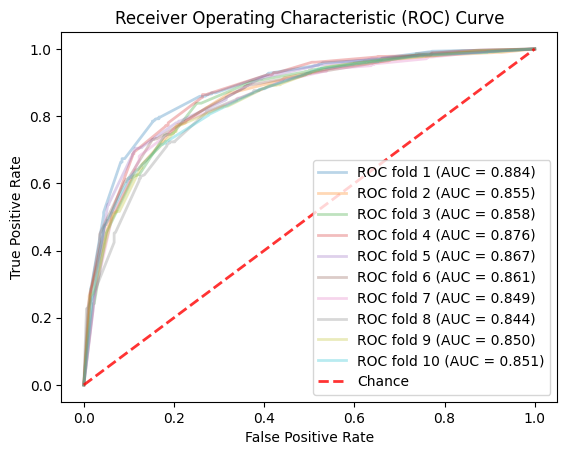

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC Curve를 그리기 위한 준비
tpr_list = []
fpr_list = []
roc_auc_list = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RandomForestClassifier(random_state=90, n_estimators=10, max_features=24, max_depth=150)
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    tpr_list.append(tpr)
    fpr_list.append(fpr)
    roc_auc_list.append(roc_auc)

# ROC Curve 그리기
plt.figure()
for i in range(len(tpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (i+1, roc_auc_list[i]))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('Stratified 10-cross validation_RF_AUROC.png')
plt.show()

평균값으로 cross validation 그래프 그리기

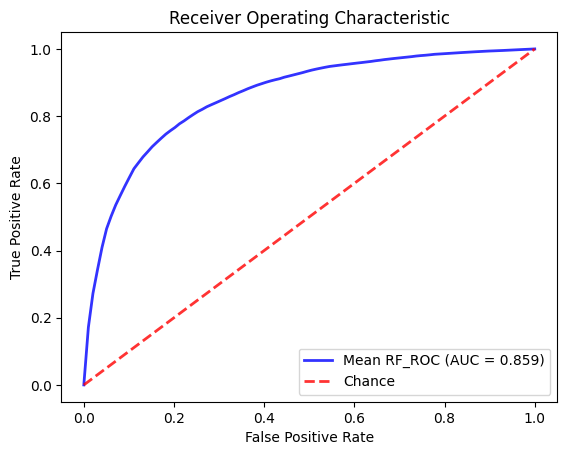

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 평균 FPR, TPR 및 AUC 계산을 위한 준비
mean_fpr = np.linspace(0, 1, 100)
tpr_list = []
roc_auc_list = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RandomForestClassifier(random_state=90, n_estimators=10, max_features=24, max_depth=150)
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    tpr_list.append(np.interp(mean_fpr, fpr, tpr))  # 각 fold의 TPR을 평균 FPR에 대해 보간
    tpr_list[-1][0] = 0.0
    roc_auc_list.append(auc(fpr, tpr))

# 평균 TPR 및 평균 AUC 계산
mean_tpr = np.mean(tpr_list, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

# 평균 ROC Curve 그리기
plt.figure()
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean RF_ROC (AUC = %0.3f)' % mean_auc, lw=2, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Standard derivation을 구해서 같이 그래프상에 표시해주기

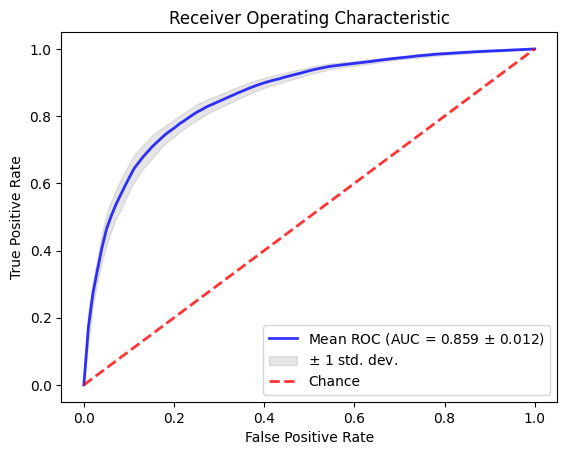

In [15]:
std_auc = np.std(roc_auc_list)
std_tpr = np.std(tpr_list, axis = 0)

#평균을 기준으로 위아래로 표준편차 만큼의 tpr 구간을 계산
tprs_upper= np.minimum(mean_tpr + std_tpr , 1)
tprs_lower= np.maximum(mean_tpr - std_tpr , 0)

# 평균 roc와 오차 막대 그리프 그리기
plt.figure()
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc), lw=2, alpha=.8)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## strarified 10-cross validation의 AUPR 그리기

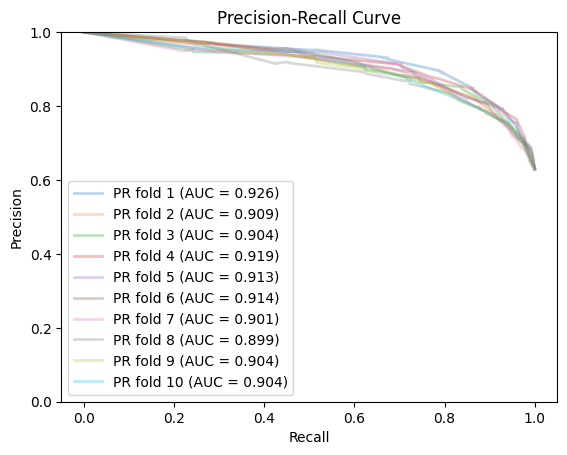

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# PR Curve를 그리기 위한 준비
precision_list = []
recall_list = []
pr_auc_list = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RandomForestClassifier(random_state=90, n_estimators=10, max_features=24, max_depth=150)
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    precision_list.append(precision)
    recall_list.append(recall)
    pr_auc_list.append(pr_auc)

# Precision-Recall Curve 그리기
plt.figure()
for i in range(len(precision_list)):
    plt.plot(recall_list[i], precision_list[i], lw=2, alpha=0.3, label='PR fold %d (AUC = %0.3f)' % (i+1, pr_auc_list[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.ylim([0.0, 1.0])  # Set the start of y-axis to 0
plt.savefig('Stratified 10-cross validation_RF_AUPR.png')
plt.show()


In [20]:
precision_list

[array([1.        , 0.99893946, 0.99787892, 0.99681838, 0.99575784,
        0.9946973 , 0.99363676, 0.99257622, 0.99151568, 0.99045514,
        0.9893946 , 0.98833405, 0.98727351, 0.98621297, 0.98515243,
        0.98409189, 0.98303135, 0.98197081, 0.98091027, 0.97984973,
        0.97878919, 0.97772865, 0.97666811, 0.97560757, 0.97454703,
        0.97348649, 0.97242595, 0.97136541, 0.97051968, 0.96801821,
        0.96636707, 0.96562191, 0.96487676, 0.96413161, 0.96338645,
        0.9626413 , 0.96189615, 0.96115099, 0.96040584, 0.95966068,
        0.95891553, 0.95817038, 0.95742522, 0.95668007, 0.95593492,
        0.95518976, 0.95444461, 0.95369945, 0.9529543 , 0.95220915,
        0.95146399, 0.95204251, 0.95070038, 0.94935825, 0.94801612,
        0.94667399, 0.94533185, 0.94398972, 0.94264759, 0.94130546,
        0.93996333, 0.9386212 , 0.93727907, 0.93593694, 0.93459481,
        0.93325268, 0.93045524, 0.92584082, 0.92310876, 0.92037671,
        0.91764465, 0.9149126 , 0.91218054, 0.90

평균값으로 AUPR cross validation 그래프 그리기

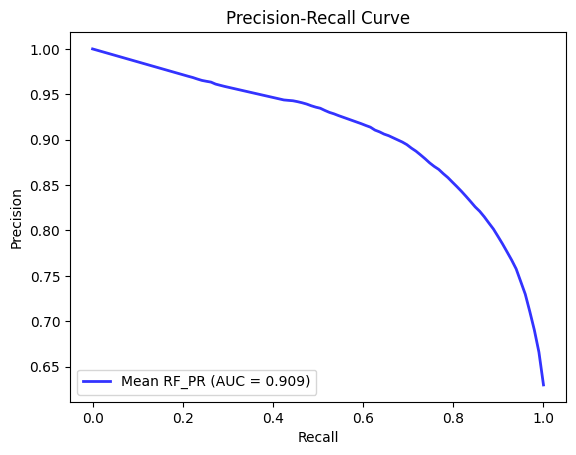

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# 평균 Precision 및 Recall 계산을 위한 준비
mean_recall = np.linspace(0, 1, 100)
precision_list = []
pr_auc_list = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RandomForestClassifier(random_state=90, n_estimators=10, max_features=24, max_depth=150)
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    precision_list.append(np.interp(mean_recall, recall[::-1], precision[::-1]))  # 각 fold의 Precision을 평균 Recall에 대해 보간
    pr_auc_list.append(auc(recall, precision))

# 평균 Precision 계산
mean_precision = np.mean(precision_list, axis=0)

# 평균 PR Curve 그리기
plt.figure()
plt.plot(mean_recall, mean_precision, color='b', label=r'Mean RF_PR (AUC = %0.3f)' % np.mean(pr_auc_list), lw=2, alpha=.8)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


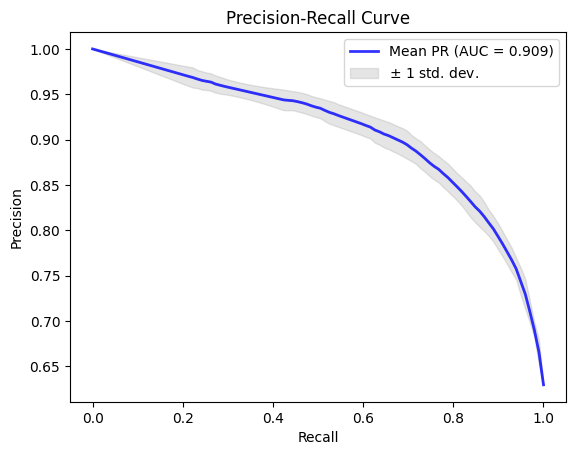

In [18]:
# Precision의 표준편차 계산
std_precision = np.std(precision_list, axis=0)

# 평균 위아래로 표준편차 만큼의 Precision 구간을 계산 (오차 막대)
precision_upper = np.minimum(mean_precision + std_precision, 1)
precision_lower = np.maximum(mean_precision - std_precision, 0)

# 평균 PR Curve와 오차 막대 그리기
plt.figure()
plt.plot(mean_recall, mean_precision, color='b', label=r'Mean PR (AUC = %0.3f)' % np.mean(pr_auc_list), lw=2, alpha=.8)
plt.fill_between(mean_recall, precision_lower, precision_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()


In [32]:
fpr_list

[array([0.        , 0.01461988, 0.01461988, 0.01754386, 0.01754386,
        0.04385965, 0.04385965, 0.04385965, 0.08187135, 0.08479532,
        0.08479532, 0.08479532, 0.08479532, 0.08479532, 0.09064327,
        0.15204678, 0.15204678, 0.15497076, 0.15789474, 0.15789474,
        0.16081871, 0.16666667, 0.16666667, 0.16666667, 0.16959064,
        0.25730994, 0.26315789, 0.26900585, 0.26900585, 0.28070175,
        0.28362573, 0.28362573, 0.29239766, 0.40643275, 0.40643275,
        0.40935673, 0.40935673, 0.4122807 , 0.52046784, 0.52046784,
        0.52923977, 0.52923977, 0.66081871, 0.66081871, 0.76608187,
        0.77192982, 0.77192982, 0.89766082, 0.90350877, 1.        ]),
 array([0.        , 0.01169591, 0.01169591, 0.01169591, 0.01169591,
        0.05263158, 0.05263158, 0.05555556, 0.05555556, 0.11403509,
        0.11403509, 0.11695906, 0.11988304, 0.12280702, 0.12280702,
        0.20760234, 0.21052632, 0.21052632, 0.21345029, 0.21929825,
        0.2251462 , 0.2251462 , 0.3245614 , 0.